#### 프로젝트 : 커스텀 프로젝트 직접 만들기
##### 학습목표
1. [X] 모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.
2. [X] Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.
3. [X] 모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.
##### 평가기준
1. [X] klue/bert-base를 NSMC 데이터셋으로 fine-tuning 하여, 모델이 정상적으로 작동하는 것을 확인하였다.
2. [X] Test accuracy를 90% 이상으로 개선하였다.
3. [X] Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.

##### 다운로드

In [1]:
# NSMC 영화 리뷰 데이터 (train/test) 다운로드
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

# 필수 라이브러리 설치
# !pip install transformers     # Hugging Face 모델
# !pip install accelerate       # 분산/최적화 학습
# !pip install datasets         # 데이터셋 처리
# !pip install evaluate         # 평가지표 계산
# !pip install wandb            # 실험 추적/시각화

##### 라이브러리

In [18]:
# 기본 라이브러리
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 데이터셋 처리
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split   # 데이터 분할

# 모델 & 학습 도구
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # 토크나이저, 분류 모델
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback  # 학습 관리, 얼리 스토핑

# 평가 지표
from evaluate import load   # 정확도, F1 등 계산

# 실험 추적
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

##### STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [19]:
# 데이터 불러오기 (NSMC train/test)
train_df = pd.read_csv("ratings_train.txt", sep="\t")
test_df = pd.read_csv("ratings_test.txt", sep="\t")
print(len(train_df))  # train 전체 개수
print(len(test_df))  # test 전체 개수

# 결측치 제거
train_df = train_df.dropna()
test_df = test_df.dropna()
print(len(train_df))  # 결측치 제거 후 train 개수
print(len(test_df))  # 결측치 제거 후 test 개수

# 중복 제거 (document 기준)
train_df = train_df.drop_duplicates(subset=["document"])
test_df = test_df.drop_duplicates(subset=["document"])
print(len(train_df))  # 중복 제거 후 train 개수
print(len(test_df))  # 중복 제거 후 test 개수

# 데이터 확인
train_df.head()

150000
50000
149995
49997
146182
49157


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [20]:
# 텍스트 전처리 함수
def clean_text(text):
    text = str(text).lower()                                     # 소문자 변환
    text = re.sub(r"[^ㄱ-ㅎ가-힣a-z0-9\s\.\,\!\?]", " ", text)   # 한글/영문/숫자/.,!? 외 제거
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)                   # 같은 문자 3번 이상 → 2번으로 축소
    text = re.sub(r"\s+", " ", text).strip()                     # 공백 정리
    return text

# train/test 데이터에 전처리 적용
train_df["document"] = train_df["document"].apply(clean_text)
test_df["document"]  = test_df["document"].apply(clean_text)

# 결과 확인
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


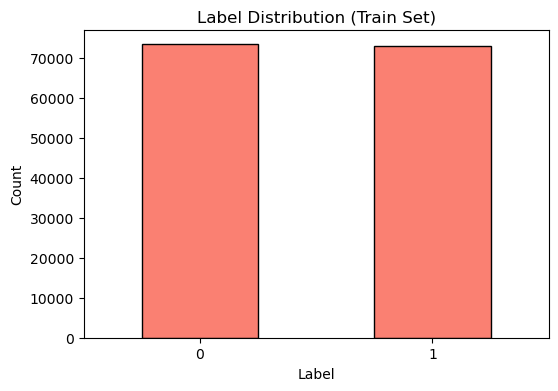

label
0    0.501717
1    0.498283
Name: proportion, dtype: float64


In [21]:
# 라벨 분포 시각화
plt.figure(figsize=(6,4))
train_df["label"].value_counts().plot(kind="bar", color="salmon", edgecolor="black")

plt.title("Label Distribution (Train Set)")  # 제목
plt.xlabel("Label")                          # X축: 라벨 (0=부정, 1=긍정)
plt.ylabel("Count")                          # Y축: 개수
plt.xticks(rotation=0)                       # 라벨 가독성 (0도 회전)
plt.show()

# 라벨 비율 확인
print(train_df["label"].value_counts(normalize=True))

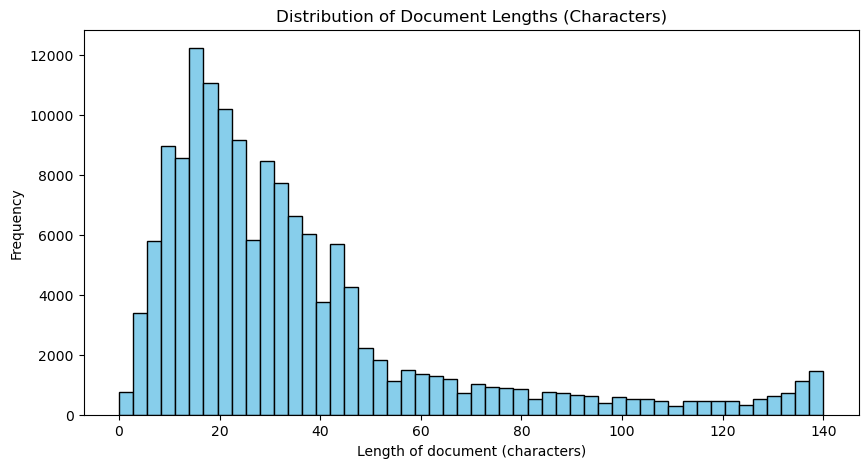

count    146182.000000
mean         35.033034
std          29.266275
min           0.000000
25%          16.000000
50%          26.000000
75%          42.000000
max         140.000000
Name: document, dtype: float64


In [22]:
# 문서 길이 분포 시각화
plt.figure(figsize=(10,5))
plt.hist(train_df["document"].apply(len), bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Document Lengths (Characters)")  # 제목
plt.xlabel("Length of document (characters)")              # X축: 문서 길이
plt.ylabel("Frequency")                                    # Y축: 빈도
plt.show()

# 문서 길이에 대한 기본 통계치 확인
print(train_df["document"].apply(len).describe())

In [23]:
# train 데이터를 train/validation 으로 분리
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,            # 20% → validation
    random_state=42,          # 재현 가능성 유지
    stratify=train_df["label"] # 라벨 비율 유지 (층화 추출)
)

# 분리된 데이터 크기 확인
print(len(train_df))   # train 개수
print(len(valid_df))   # validation 개수
print(len(test_df))    # test 개수

116945
29237
49157


In [24]:
# Pandas → Hugging Face Dataset 변환
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset  = Dataset.from_pandas(test_df)

# DatasetDict 형태로 묶기 (Trainer에서 사용하기 편리)
nsmc_dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

# 데이터셋 구조 출력
print(nsmc_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 116945
    })
    validation: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 29237
    })
    test: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 49157
    })
})


##### STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [25]:
# KLUE-BERT 토크나이저 불러오기
kluebert_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
print(kluebert_tokenizer.vocab_size)   # 단어 집합 크기 출력

# KLUE-BERT 분류 모델 불러오기 (이진 분류 → num_labels=2)
kluebert_model = AutoModelForSequenceClassification.from_pretrained(
    "klue/bert-base",
    num_labels=2
)
print(kluebert_model)  # 모델 구조 출력

32000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##### STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하기

In [26]:
# 토큰화 함수 정의
def tokenize(batch):
    return kluebert_tokenizer(
        batch["document"],
        truncation=True,       # 길면 자르기
        padding="max_length",  # 고정 길이 패딩
        max_length=128         # 최대 길이
    )

# 전체 데이터셋 토큰화
tokenized_dataset = nsmc_dataset.map(tokenize, batched=True)

# 불필요한 열 제거 (id는 안 씀)
tokenized_dataset = tokenized_dataset.remove_columns(["id"])

# PyTorch 텐서 형태로 변환
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/116945 [00:00<?, ? examples/s]

Map:   0%|          | 0/29237 [00:00<?, ? examples/s]

Map:   0%|          | 0/49157 [00:00<?, ? examples/s]

In [27]:
# 토큰화된 샘플 확인
print(tokenized_dataset["train"][0])        # train 첫 샘플
print(tokenized_dataset["validation"][0])   # validation 첫 샘플
print(tokenized_dataset["test"][0])         # test 첫 샘플

{'document': '허니잼 예스잼 꿀잼 잼잼', 'label': tensor(1), '__index_level_0__': tensor(3514), 'input_ids': tensor([    2, 17945,  3468, 19704,  3468,   692,  3468,  1530,  3468,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

##### STEP 4. 모델 Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

In [12]:
training_arguments = TrainingArguments(
    output_dir="./result1",          # 결과 저장 경로
    eval_strategy="epoch",           # 에폭마다 평가
    save_strategy="epoch",           # 에폭마다 체크포인트 저장
    learning_rate=2e-5,              # 학습률
    per_device_train_batch_size=32,  # GPU/장치당 train 배치 크기
    per_device_eval_batch_size=32,   # GPU/장치당 eval 배치 크기
    num_train_epochs=5,              # 학습 epoch 수
    weight_decay=0.01,               # 가중치 감쇠 (L2 정규화)
    load_best_model_at_end=True,     # 가장 좋은 모델 불러오기
    metric_for_best_model="eval_loss", # 기준 메트릭 (평가 손실)
    greater_is_better=False,         # 손실은 낮을수록 좋음
    logging_strategy="epoch",        # 에폭마다 로그 기록
    report_to="wandb",               # W&B에 기록
    seed=42                          # 랜덤 시드 고정
)

In [13]:
# 평가 지표 불러오기
accuracy  = load("accuracy")
precision = load("precision")
recall    = load("recall")
f1        = load("f1")
roc_auc   = load("roc_auc")

# 모델 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)  # 예측 라벨
    probs = logits[:, 1]                # positive 클래스 확률

    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels),
        "precision": precision.compute(predictions=preds, references=labels, average="binary"),
        "recall":    recall.compute(predictions=preds, references=labels, average="binary"),
        "f1":        f1.compute(predictions=preds, references=labels, average="binary"),
        "roc_auc":   roc_auc.compute(prediction_scores=probs, references=labels),
    }

In [14]:
# Hugging Face Trainer 설정
trainer = Trainer(
    model=kluebert_model,                       # 학습할 모델
    args=training_arguments,                    # 학습 설정
    train_dataset=tokenized_dataset["train"],   # 학습 데이터
    eval_dataset=tokenized_dataset["validation"], # 검증 데이터
    compute_metrics=compute_metrics,            # 평가 지표 함수
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # 조기 종료 (1 epoch 개선 없으면 stop)
)

# 모델 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.283200,0.262883,{'accuracy': 0.8954065054554161},{'precision': 0.872926386728875},{'recall': 0.9246979681493684},{'f1': 0.8980666666666667},{'roc_auc': 0.9640484548867451}
2,0.186400,0.244163,{'accuracy': 0.9054964599651127},{'precision': 0.9056979861158843},{'recall': 0.9045167490389896},{'f1': 0.9051069821753615},{'roc_auc': 0.9670953810366174}
3,0.121500,0.314894,{'accuracy': 0.905222834080104},{'precision': 0.8933644548182728},{'recall': 0.9195496979681493},{'f1': 0.9062679700977573},{'roc_auc': 0.9648453060803679}


TrainOutput(global_step=10965, training_loss=0.1970232322125798, metrics={'train_runtime': 7729.8015, 'train_samples_per_second': 75.646, 'train_steps_per_second': 2.364, 'total_flos': 2.30771417768064e+16, 'train_loss': 0.1970232322125798, 'epoch': 3.0})

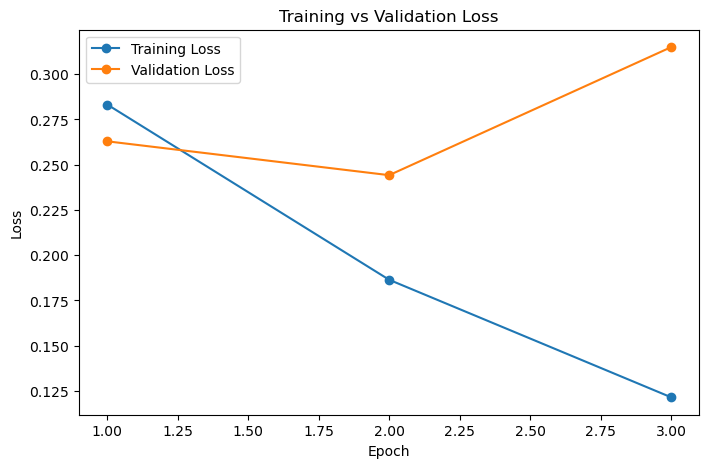

In [43]:
# DataFrame 생성
result1 = {
    "Epoch": [1, 2, 3],
    "Training Loss": [0.2832, 0.1864, 0.1215],
    "Validation Loss": [0.2629, 0.2442, 0.3149],
    "Accuracy": [0.8954, 0.9055, 0.9052],
    "Precision": [0.8729, 0.9057, 0.8934],
    "Recall": [0.9247, 0.9045, 0.9195],
    "F1": [0.8981, 0.9051, 0.9063],
    "Roc Auc": [0.9640, 0.9671, 0.9648],
}
result1_df = pd.DataFrame(result1)

# Loss 곡선 시각화
plt.figure(figsize=(8,5))
plt.plot(result1_df["Epoch"], result1_df["Training Loss"], marker="o", label="Training Loss")
plt.plot(result1_df["Epoch"], result1_df["Validation Loss"], marker="o", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(False)
plt.show()

In [15]:
# 학습된 모델을 test 데이터셋으로 평가
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.2515687346458435,
 'eval_accuracy': {'accuracy': 0.9015603067721789},
 'eval_precision': {'precision': 0.9039352792909993},
 'eval_recall': {'recall': 0.8998017077414916},
 'eval_f1': {'f1': 0.901863757123446},
 'eval_roc_auc': {'roc_auc': 0.9655558276584956},
 'eval_runtime': 342.2997,
 'eval_samples_per_second': 143.608,
 'eval_steps_per_second': 4.49,
 'epoch': 3.0}

##### STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

In [28]:
training_arguments = TrainingArguments(
    output_dir="./result2",          # 결과 저장 경로
    eval_strategy="epoch",           # 에폭마다 평가
    save_strategy="epoch",           # 에폭마다 체크포인트 저장
    learning_rate=2e-5,              # 학습률
    per_device_train_batch_size=32,  # train 배치 크기
    per_device_eval_batch_size=32,   # eval 배치 크기
    num_train_epochs=5,              # 학습 epoch 수
    weight_decay=0.01,               # 가중치 감쇠
    group_by_length=True,            # 문장 길이 기준으로 버킷팅 (패딩 효율 ↑)
    load_best_model_at_end=True,     # 가장 좋은 모델 불러오기
    metric_for_best_model="eval_loss", # 기준 메트릭: 평가 손실
    greater_is_better=False,         # 손실은 낮을수록 좋음
    logging_strategy="epoch",        # 에폭마다 로그 기록
    report_to="wandb",               # W&B에 기록
    seed=42                          # 랜덤 시드 고정
)

In [29]:
# 평가 지표 불러오기
accuracy  = load("accuracy")
precision = load("precision")
recall    = load("recall")
f1        = load("f1")
roc_auc   = load("roc_auc")

# 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)  # 가장 큰 확률 → 예측 라벨
    probs = logits[:, 1]                # positive(1) 클래스 확률

    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall":    recall.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1":        f1.compute(predictions=preds, references=labels, average="binary")["f1"],
        "roc_auc":   roc_auc.compute(prediction_scores=probs, references=labels)["roc_auc"],
    }

In [31]:
# Trainer 설정
trainer = Trainer(
    model=kluebert_model,                        # 학습할 모델
    args=training_arguments,                     # 학습 파라미터
    train_dataset=tokenized_dataset["train"],    # 학습 데이터
    eval_dataset=tokenized_dataset["validation"],# 검증 데이터
    compute_metrics=compute_metrics,             # 평가 지표 함수
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # 조기 종료 (1epoch 개선 없으면 stop)
)

# 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.283500,0.245627,0.901289,0.902772,0.898682,0.900722,0.964518
2,0.186200,0.246023,0.905223,0.895103,0.917284,0.906058,0.966906


TrainOutput(global_step=7310, training_loss=0.23487719993747863, metrics={'train_runtime': 5159.9712, 'train_samples_per_second': 113.319, 'train_steps_per_second': 3.542, 'total_flos': 1.53847611845376e+16, 'train_loss': 0.23487719993747863, 'epoch': 2.0})

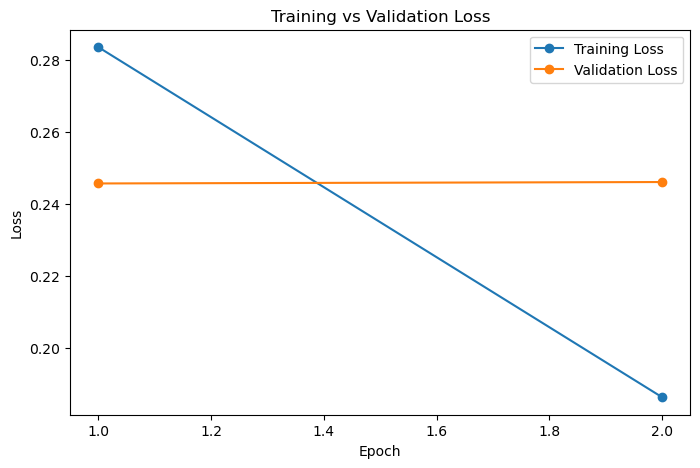

In [42]:
# DataFrame 생성
result2 = {
    "Epoch": [1, 2],
    "Training Loss": [0.283500, 0.186200],
    "Validation Loss": [0.245627, 0.246023],
    "Accuracy": [0.901289, 0.905223],
    "Precision": [0.902772, 0.895103],
    "Recall": [0.898682, 0.917284],
    "F1": [0.900722, 0.906058],
    "Roc Auc": [0.964518, 0.966906],
}
result2_df = pd.DataFrame(result2)

# Loss 곡선 시각화
plt.figure(figsize=(8,5))
plt.plot(result2_df["Epoch"], result2_df["Training Loss"], marker="o", label="Training Loss")
plt.plot(result2_df["Epoch"], result2_df["Validation Loss"], marker="o", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(False)
plt.show()

In [39]:
# 학습된 모델을 test 데이터셋으로 평가
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.2500600814819336,
 'eval_accuracy': 0.8984071444555201,
 'eval_precision': 0.9012250213666517,
 'eval_recall': 0.8961191372263364,
 'eval_f1': 0.8986648269144921,
 'eval_roc_auc': 0.9635472886497553,
 'eval_runtime': 345.025,
 'eval_samples_per_second': 142.474,
 'eval_steps_per_second': 4.455,
 'epoch': 2.0}

##### 결과

In [46]:
result1 = {
    "Accuracy": 0.9016,
    "Precision": 0.9039,
    "Recall": 0.8998,
    "F1": 0.9019,
    "Roc Auc": 0.9656
}

result2 = {
    "Accuracy": 0.8984,
    "Precision": 0.9012,
    "Recall": 0.8961,
    "F1": 0.8987,
    "Roc Auc": 0.9635
}

df = pd.DataFrame([result1, result2], index=["Result1", "Result2"])
df

,Accuracy,Precision,Recall,F1,Roc Auc
Result1,0.9016,0.9039,0.8998,0.9019,0.9656
Result2,0.8984,0.9012,0.8961,0.8987,0.9635


#### 프로젝트 회고

KLUE-BERT 모델을 NSMC 데이터셋으로 파인튜닝하여 한국어 감정 분석 이진 분류 모델을 구축했다. 목표는 Test Accuracy 90% 이상 달성과 함께, 부켓팅(bucketting) 적용 여부에 따른 연산 속도와 성능 간 트레이드오프를 검증하는 것이었다.

##### 1. 데이터셋과 전처리
- NSMC: train 150,000 / test 50,000, label은 0·1 이진
- 결측치·중복 제거 후: train 146,182 / test 49,157
- 텍스트 정제: 영문 소문자화, 한글·영문·숫자·.,!? 유지, 3회 이상 반복 문자는 2회로 축소, 공백 정리
- 라벨 분포는 거의 5:5, 문서 길이는 우측 꼬리(long-tail)

##### 2. 분할과 토크나이징
- train/val/test = 116,945 / 29,237 / 49,157
- KLUE-BERT 토크나이저 사용, vocab size = 32,000

##### 3. 실험 설계
- 동일 모델·동일 하이퍼파라미터
- 차이점: 부켓팅 적용 여부만 변경
- early stopping 기준: validation loss 악화 시 중단
  - 부켓팅 미적용: epoch 3에서 중단
  - 부켓팅 적용: epoch 2에서 중단

##### 4. 성능 결과 (검증 세트)

| 조건       | Accuracy | Precision | Recall | F1     | ROC AUC |
|------------|----------|-----------|--------|--------|---------|
| 부켓팅 X   | 0.9016   | 0.9039    | 0.8998 | 0.9019 | 0.9656  |
| 부켓팅 O   | 0.8984   | 0.9012    | 0.8961 | 0.8987 | 0.9635  |

해석: 부켓팅 미적용이 전 지표에서 근소하게 더 우수했다.

##### 5. 학습 속도 비교

| 조건       | 학습 시간(hh:mm:ss) | steps/sec | samples/sec | epoch | global_step |
|------------|----------------------|-----------|-------------|-------|-------------|
| 부켓팅 X   | 02:08:50             | 2.364     | 75.646      | 3.0   | 10,965      |
| 부켓팅 O   | 01:26:00             | 3.542     | 113.319     | 2.0   | 7,310       |

해석: 부켓팅 적용 시 처리 속도는 약 1.5배 빨라졌지만, 최종 성능은 소폭 하락했다.

##### 6. 평가지표 선택 이유

- Accuracy  
  클래스 분포가 거의 5:5로 균형이라 전체 정답률이 의미 있다. 다만 오검 유형을 구분하지 못하므로 단독 평가는 한계가 있다.

- Precision  
  긍정(또는 부정)으로 예측한 것 중 실제로 맞춘 비율. 오탐(false positive)을 줄이는 능력을 본다. 사용자 알림·추천 등에서 오탐 비용이 높을 때 중요하다.

- Recall  
  실제 긍정(또는 부정) 중에서 모델이 놓치지 않고 찾아낸 비율. 미탐(false negative)을 줄이는 능력을 본다. 민감도(sensitivity)가 중요한 안전·품질 시나리오에서 중요하다.

- F1  
  Precision과 Recall의 조화 평균으로 두 지표의 균형을 본다. 어느 한쪽만 높은 모델을 경계하는 데 유용하다.

- ROC AUC  
  분류 임계값(threshold)에 독립적인 순위화 능력 지표. 다양한 운영 임계값에서의 평균적 판별력(민감도-특이도 트레이드오프)을 확인할 수 있어, 배포 환경에서 임계값을 조정할 여지가 있을 때 특히 유용하다.

##### 7. 결론

부켓팅 적용은 steps/sec과 samples/sec 지표에서 확인되듯 학습 효율을 뚜렷하게 개선했다. 그러나 본 실험 환경과 NSMC 데이터셋에서는 검증 성능이 소폭 하락하는 양상이 나타났다. 목표로 삼았던 Test Accuracy 90% 이상은 부켓팅을 적용하지 않았을 때 달성할 수 있었다. 따라서 운영 환경에서 속도가 더 중요하다면 부켓팅 적용이 적절하고, 최종 성능을 극대화하는 것이 우선이라면 부켓팅을 적용하지 않는 편이 더 적합하다.

##### 8. 다음 과제

- 데이터 길이 분포 개선  
  현재 document 길이가 오른쪽으로 꼬리가 긴(long-tail) 형태를 보인다. 지나치게 긴 문장들은 학습 안정성을 저해하는 노이즈로 작용할 수 있으므로, 일정 길이 이상을 제거하거나 잘라내어 분포를 더 정규화시키는 방안을 검토한다.

- 학습 안정화 및 성능 향상  
  전통적인 Grid search나 Random search 방식의 하이퍼파라미터 탐색은 대규모 모델 학습에서는 비효율적이다. 대신 학습률 스케줄러(cosine decay, linear decay, warmup 등)와 적절한 weight decay, dropout 비율 조정 등으로 안정성과 성능을 개선하는 방향을 모색한다. 또한 early stopping에서 patience를 1로 두는 것은 지나치게 보수적이므로, 2~3으로 늘려 모델이 수렴할 수 있는 여지를 확보한 뒤 실험을 진행한다.


##### 9. 회고
 Hugging Face 프레임워크를 활용해 데이터셋 구성, 파인튜닝, 추론까지 진행했는데 전체 과정이 간단하고 직관적이었다. 앞으로 Hugging Face에 더 익숙해진다면, PyTorch의 유연성을 살려 직접 데이터로더나 학습 루프를 구성하는 방식과 Hugging Face의 Trainer를 통한 자동화된 학습 방식을 상황에 맞게 병행할 수 있을 것으로 보인다. 또한 Trainer를 Weights & Biases와 연동하니 실험 결과가 체계적으로 기록·시각화되어 관리 효율성이 높았다.  

 이번 실험에서는 버켓팅(bucketting) 적용 여부가 학습 속도와 성능에 어떤 영향을 주는지를 확인할 수 있었다. 버켓팅은 문장 길이가 비슷한 샘플을 묶어 배치를 구성하는 방식으로, 불필요한 패딩을 줄여 처리 속도를 높여주는 장점이 있다. 다만 배치가 길이 기준으로 고정되다 보니 무작위성이 줄어들어 데이터 다양성이 낮아질 수 있다는 한계도 있다. 따라서 문장 길이 분포가 균일하다면 버켓팅 여부에 따른 차이는 거의 없을 것이고, 반대로 길이 분포가 긴 꼬리를 가진 경우에는 속도 개선 효과가 더욱 두드러질 수 있다.